In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import csv

In [ ]:
file_path = 'data/ecommerceDataset.csv'
dataset = pd.read_csv(file_path)

In [ ]:
dataset.columns = ['Category', 'Text']
codes = {'Household':0, 'Books':1, 'Clothing & Accessories':2, 'Electronics':3}
dataset['Category_code'] = dataset['Category'].apply(lambda x: codes[x])

In [ ]:
dataset[0:2]

,Category,Text,Category_code
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",0
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,0


## Data Analizing

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
dataset = dataset.dropna()

In [ ]:
def stat(data, log=False):

  x=data.groupby('Category', as_index=False).count()
  sns.countplot(x=data['Category'])
  plt.show()

  data['len'] = data['Text'].apply(lambda x: len(x.split(' ')))
  max_words = data['len'].max()

  sns.kdeplot(x='len',
              hue='Category',
              fill=True,
              data=data)

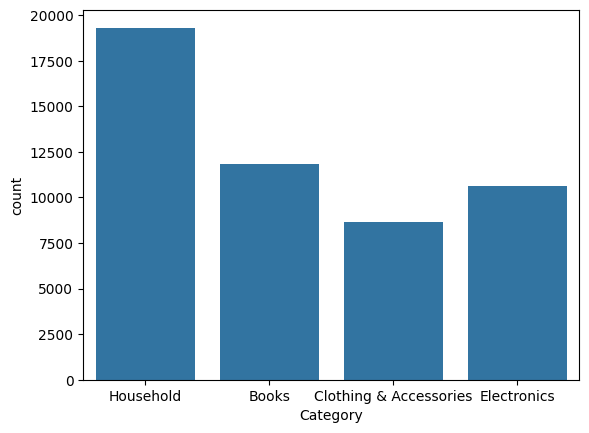

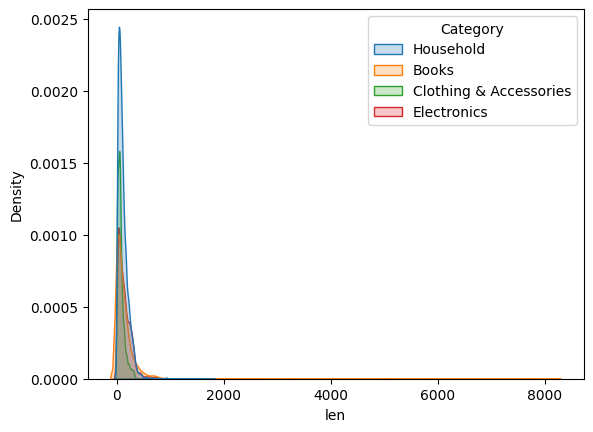

In [ ]:
stat(dataset)

## Data normalize

In [ ]:
from tqdm import tqdm

In [ ]:
def filter_sentence_length(data, shortest, longest):
  dataset_sorted = dataset.sort_values(by=['len'])
  length = len(data)

  filtered_dataset = dataset_sorted[int(length * shortest) : length - int(length * longest)]

  return filtered_dataset

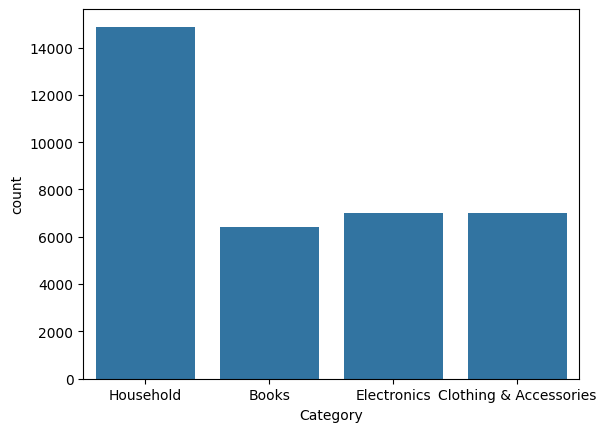

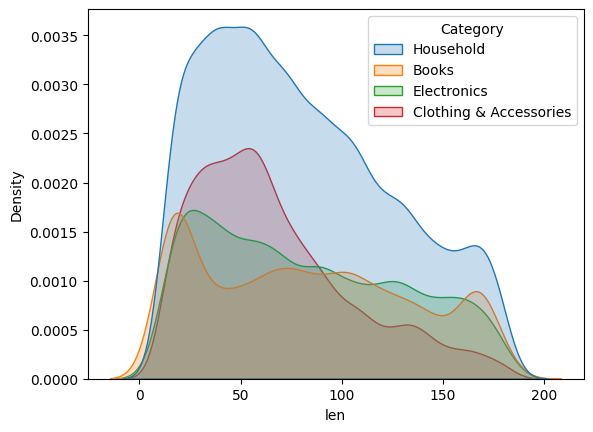

In [ ]:
norm_data = filter_sentence_length(dataset, 0.1, 0.2)
stat(norm_data, True)

In [ ]:
def make_equal_balance(data):
  c = Counter(norm_data['Category_code'])
  min = c.most_common()[-1][0]
  data_min = data[data['Category_code'] == min]
  df = data_min

  for part in c:
    part_df = data[data['Category_code'] == part]
    if part != min:
      part_df = part_df.sample(n=c[min], random_state=101)
      df = pd.concat([df,part_df],axis=0)
  df = df.sample(frac=1).reset_index(drop=True)

  return df

In [ ]:
data = norm_data
data = make_equal_balance(data)

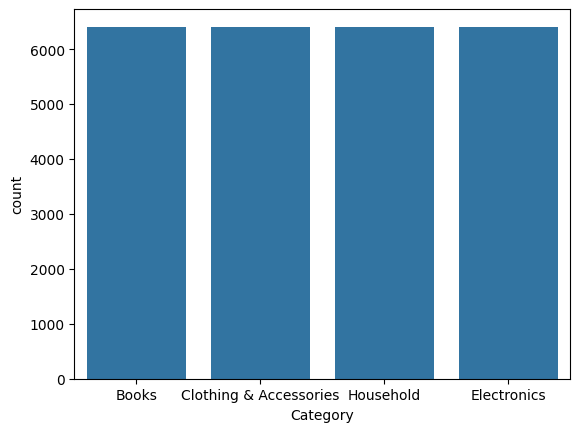

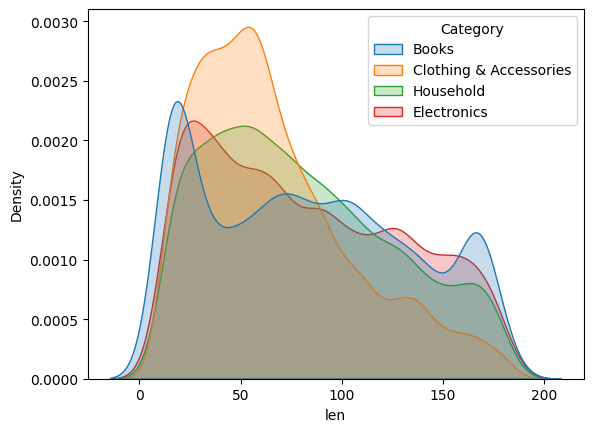

In [ ]:
stat(data)

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import re
import string

In [ ]:
def str_preprocess(text: str)->list:
    """
    Function to clean text and create lemmas
    """
    reg = re.compile('[^а-яА-яa-zA-Z0-9 ]') #
    text = text.lower().replace("ё", "е")
    text = text.replace("ъ", "ь")
    text = text.replace("й", "и")
    text = text.replace("\\n", "")
    text = text.replace("\\r", "")
    text = text.replace("\\t", "")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'сайт', text)
    text = re.sub('@[^\s]+', 'пользователь', text)
    text = reg.sub(' ', text)

    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]
    stopWords = set(stopwords.words('english'))

    text =  " ".join([word for word in text.split() if word not in SYMBOLS])
    text =[lemmatizer.lemmatize(word) for word in text.split() if word not in stopWords]
    return ' '.join(text)

In [ ]:
tqdm.pandas()

In [ ]:
data

,Category,Text,Category_code,len
0,Books,25 Years AIIMS Chapterwise Solutions -Biology ...,1,94
1,Books,Fundamentals of Digital Marketing by Pearson A...,1,97
2,Clothing & Accessories,Milano Women's Cotton Floral Embroidery Hankie...,2,28
3,Household,Resqtech 25 Liter 12V Dc Bucket Car Washer - Y...,0,102
4,Electronics,HP 12A Black Original LaserJet Toner Cartridge...,3,104
...,...,...,...,...
25631,Household,DI GRAZIA Ceramic Rabbit Cartoon Bunny Theme K...,0,155
25632,Clothing & Accessories,"To The Nines Men's Tie, Pocket Square & Cuff l...",2,18
25633,Clothing & Accessories,Sona Women's Sports Bra Non Padded for Gym & Y...,2,168
25634,Household,Pistily Storage Box- Jewellery & Trinket Stora...,0,168


In [ ]:
data['clean_text'] = data.progress_apply(lambda x : str_preprocess(x['Text']), axis=1)

100%|██████████| 25636/25636 [00:17<00:00, 1426.54it/s]


In [ ]:
data.head()

,Category,Text,Category_code,len,clean_text
0,Books,25 Years AIIMS Chapterwise Solutions -Biology ...,1,94,25 year aiims chapterwise solution biology 201...
1,Books,Fundamentals of Digital Marketing by Pearson A...,1,97,fundamental digital marketing pearson author p...
2,Clothing & Accessories,Milano Women's Cotton Floral Embroidery Hankie...,2,28,milano woman cotton floral embroidery hanky mu...
3,Household,Resqtech 25 Liter 12V Dc Bucket Car Washer - Y...,0,102,resqtech 25 liter 12v dc bucket car washer yel...
4,Electronics,HP 12A Black Original LaserJet Toner Cartridge...,3,104,hp 12a black original laserjet toner cartridge...


In [ ]:
data.to_csv('dataset.csv')

## Classic ML methods

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
df = pd.read_csv('./dataset.csv', index_col = 0)

In [ ]:
df['Text'] = df['clean_text']
df = df[['Text', 'Category_code']]

In [ ]:
df

,Text,Category_code
0,medha j plus 500w professional high power pa a...,3
1,hanes men plain thermal bottom hanes men white...,2
2,pindia heart polyester window thread curtain 6...,0
3,u polo assn men cotton pyjama bottom u polo as...,2
4,castor smart cool 20 litre 3 level speed inver...,0
...,...,...
25631,red tape men waistcoat elegant tailoring defin...,2
25632,introduction chemical engineering author salil...,1
25633,sony x gtx122lt box subwoofer black pp mica re...,3
25634,tucute woman beautiful check print border feed...,2


### Test/Train splitting

In [ ]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(df['Text'],
                                                    df['Category_code'],
                                                    test_size=test_size,
                                                    random_state=42)


### Bag of Words text representation

In [ ]:
vectorizer = CountVectorizer()
X_train_coded = vectorizer.fit_transform(X_train)
X_test_coded = vectorizer.transform(X_test)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_coded, y_train)
y_pred = clf.predict(X_test_coded)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1929
           1       0.97      0.96      0.97      1917
           2       0.98      0.98      0.98      1993
           3       0.96      0.97      0.96      1852

    accuracy                           0.97      7691
   macro avg       0.97      0.97      0.97      7691
weighted avg       0.97      0.97      0.97      7691



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
def plot_confusion(y_test, y_pred):
    dict_normal_names = {0:'Household', 1:'Books', 2:'Clothing & Accessories', 3:'Electronics'}
    data = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(data, columns = list(map(dict_normal_names.get, list(np.unique(y_test)))),
                                index = list(map(dict_normal_names.get, list(np.unique(y_test)))))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    f, ax = plt.subplots(figsize=(4, 5))
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)

    sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
                annot_kws={'size': 10})
    plt.title('Actuals vs Predicted')
    plt.show()

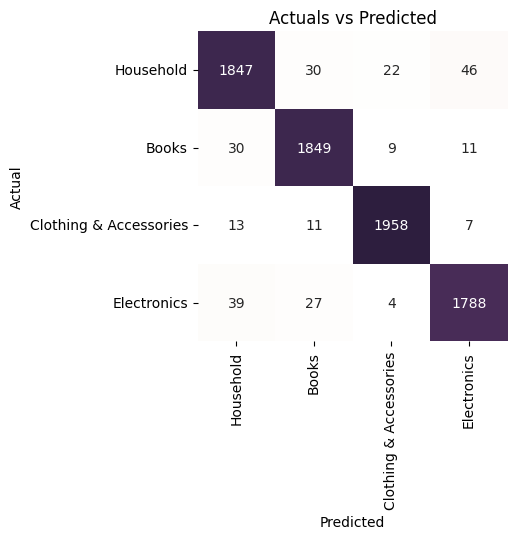

In [ ]:
plot_confusion(y_test, y_pred)

### TF-IDF text representation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_coded = vectorizer.fit_transform(X_train)
X_test_coded = vectorizer.transform(X_test)

In [ ]:
clf = LogisticRegression(random_state=0).fit(X_train_coded, y_train)
y_pred = clf.predict(X_test_coded)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1990
           1       0.95      0.97      0.96      1860
           2       0.98      0.98      0.98      1999
           3       0.95      0.96      0.95      1842

    accuracy                           0.96      7691
   macro avg       0.96      0.96      0.96      7691
weighted avg       0.96      0.96      0.96      7691



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


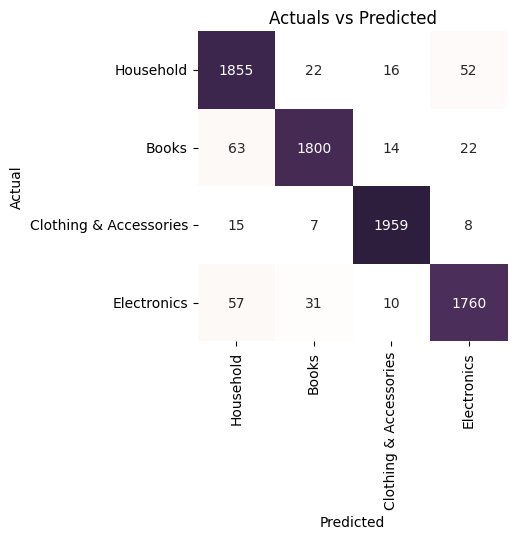

In [ ]:
plot_confusion(y_test, y_pred)

### 2.4 Сравнение различных моделей для метода TF-IDF

In [ ]:
def get_models():
    return {'RandomForest': RandomForestClassifier(bootstrap=True,
                                                   n_estimators=100,
                                                   n_jobs=-1),
           "GB":GradientBoostingClassifier(n_estimators=100),
            "kNN":KNeighborsClassifier(),
            "LogisticRegression":LogisticRegression(),
            "SVC":SVC(kernel='rbf')}

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_TFIDF = vectorizer.fit_transform(X_train)
X_test_TFIDF = vectorizer.transform(X_test)

metrics = {}
models = get_models()
for name, model in tqdm(models.items()):
    print(name)
    clf = model.fit(X_train_TFIDF, y_train)
    y_predict_TFIDF = clf.predict(X_test_TFIDF)
    score = f1_score(y_predict_TFIDF, y_test, average='macro')
    metrics[name] = score


  0%|          | 0/5 [00:00<?, ?it/s]

RandomForest


 20%|██        | 1/5 [00:44<02:59, 44.99s/it]

GB


 40%|████      | 2/5 [03:43<06:10, 123.58s/it]

kNN


 60%|██████    | 3/5 [08:56<06:59, 209.91s/it]

LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 80%|████████  | 4/5 [09:07<02:11, 131.46s/it]

SVC


100%|██████████| 5/5 [11:20<00:00, 136.05s/it]


In [ ]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index').reset_index()
df_metrics.columns = ['model', 'f1_score']

In [ ]:
df_metrics

,model,f1_score
0,RandomForest,0.960195
1,GB,0.923729
2,kNN,0.947166
3,LogisticRegression,0.958580
4,SVC,0.970155


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_coded = vectorizer.fit_transform(X_train)
X_test_coded = vectorizer.transform(X_test)
clf = LogisticRegression(random_state=0).fit(X_train_coded, y_train)
y_pred = clf.predict(X_test_coded)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1990
           1       0.95      0.97      0.96      1860
           2       0.98      0.98      0.98      1999
           3       0.95      0.96      0.95      1842

    accuracy                           0.96      7691
   macro avg       0.96      0.96      0.96      7691
weighted avg       0.96      0.96      0.96      7691



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Save model for future API
from joblib import dump, load
dump(clf, './logistic_reg_model.joblib')

In [ ]:
# Save vectorizer for future API
dump(vectorizer, 'vectorizer_tfidf.pkl', compress=True)

## Классификация текста с помощью LSTM


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [ ]:
# df['Text'] = df['clean_text'].astype(str)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df['Text'], df['Category_code'],
                                                    test_size=0.25, random_state=434)

In [ ]:
x_train

In [ ]:
# Defining pre-processing parameters
max_len = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 1500

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [ ]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

38843

In [ ]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (19227, 100)
Shape of testing tensor:  (6409, 100)


In [ ]:
# Define parameter
embedding_dim = 32 # size for embeding of word
n_dense = 24# Define Dense Model Architecture
n_lstm = 64
drop_lstm = 0.1# Define LSTM Model

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(drop_lstm))
model.add(LSTM(n_lstm, return_sequences=False))
model.add(Dropout(drop_lstm))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [ ]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = tqdm(model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2))

Epoch 1/30
601/601 - 54s - loss: -1.2679e+01 - accuracy: 0.2500 - val_loss: -2.2011e+01 - val_accuracy: 0.2498 - 54s/epoch - 90ms/step
Epoch 2/30
601/601 - 61s - loss: -3.0246e+01 - accuracy: 0.2501 - val_loss: -3.9512e+01 - val_accuracy: 0.2498 - 61s/epoch - 101ms/step
Epoch 3/30
601/601 - 46s - loss: -4.7370e+01 - accuracy: 0.2501 - val_loss: -5.6811e+01 - val_accuracy: 0.2498 - 46s/epoch - 77ms/step
Epoch 4/30
601/601 - 37s - loss: -6.4484e+01 - accuracy: 0.2501 - val_loss: -7.4449e+01 - val_accuracy: 0.2498 - 37s/epoch - 61ms/step
Epoch 5/30
601/601 - 38s - loss: -8.1847e+01 - accuracy: 0.2501 - val_loss: -9.1966e+01 - val_accuracy: 0.2498 - 38s/epoch - 63ms/step
Epoch 6/30
601/601 - 37s - loss: -9.9318e+01 - accuracy: 0.2501 - val_loss: -1.0953e+02 - val_accuracy: 0.2498 - 37s/epoch - 62ms/step
Epoch 7/30
601/601 - 65s - loss: -1.1200e+02 - accuracy: 0.2504 - val_loss: -7.7094e+01 - val_accuracy: 0.2496 - 65s/epoch - 108ms/step
Epoch 8/30
601/601 - 38s - loss: -1.0055e+02 - accura

0it [00:00, ?it/s]

In [ ]:
model.evaluate(testing_padded, y_test)

201/201 [==============================] - 4s 18ms/step - loss: -718.8407 - accuracy: 0.4436


[-718.8406982421875, 0.44359493255615234]

## Классификация текста с помощью BERT

In [ ]:
from tqdm import tqdm
import pandas as pd

In [ ]:
import tensorflow as tf

In [ ]:
!pip install Cython

In [ ]:
# Import the necessary libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification

In [ ]:
df = pd.read_csv('./dataset.csv', index_col = 0)

In [ ]:
df['Text'] = df['clean_text']
df = df[['Text', 'Category_code']]

In [ ]:
df

In [ ]:
X = df['Text']
y = df['Category_code']
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size = 0.20)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4, dtype='float32')
y_test = tf.keras.utils.to_categorical(y_test, num_classes=4, dtype='float32')

In [ ]:
!pip install keras-nlp --upgrade

In [ ]:
from tensorflow import keras
import keras_nlp

In [ ]:
model_name = "bert_tiny_en_uncased"
# Pretrained classifier.
classifier = keras_nlp.models.BertClassifier.from_preset(
    model_name,
    num_classes=4,
    load_weights = True,
    activation='sigmoid'
)

/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:46: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_nlp/src/models/backbone.py:46: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
classifier.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    jit_compile=True,
     metrics=["accuracy"],
)

In [ ]:
# Access backbone programatically (e.g., to change `trainable`).
classifier.backbone.trainable = False

In [ ]:
# Fit again.
classifier.fit(x=X_train, y=y_train, validation_data=(X_test,y_test), batch_size=32)

641/641 [==============================] - 2298s 4s/step - loss: 0.1370 - accuracy: 0.9214 - val_loss: 0.0827 - val_accuracy: 0.9534


In [ ]:
classifier.evaluate(X_test, y_test,batch_size=32)

161/161 [==============================] - 121s 749ms/step - loss: 0.0827 - accuracy: 0.9534


[0.08271922171115875, 0.9533931612968445]